# Automatic differentiation: a backpropagation example for genetic programming

The purpose of this notebook is to demonstrate how weights can be learned for programs made up of differentiable nodes. In this case we're concerned with stack-based representations of mathematical functions, such as 

[ x1 x2 + sin ] $\rightarrow sin(x1+x2)$

or with embedded weights, $w_4 \cdot \sin( w_3 \cdot ( w_1 \cdot x_1 + w_2 \cdot x_2) ) $

In [37]:
# define node classes
# Need to figure out how to work in batch gradient descent, problem with variables not knowing their value
# Might want to consider changing implementation to using a "counter/pointer" instead of using the bp_stack
# need to integrate cost function

# Update now default updates all weights
# bush to backprop
# Deal with elements that aren't differentiable (keep executing branch but skip past that value)
# How to breakup cost function - cost evaluated and stored for the program might not be the 

# keep in mind parallel ability for future implementations (in terms of nodes)

# Need separate copies for separate weights
class Variable():
    def __init__(self,loc=0):
        self.loc = loc
        self.name='x_'+str(loc)
        self.arity=0
        self.visits=0
                
    def evaluate(self,stack,X=None):
        stack.append(X[:,self.loc])
    
class Add():
    def __init__(self, W=None):
        self.name='+'
        self.arity=2
        self.visits=0
        
        # Technically have vulnerability to lists of non numbers
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0, 1.0]
            
    def evaluate(self,stack,X=None):
        stack.append(self.W[0]*stack.pop() + self.W[1]*stack.pop())
        
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
            
        if loc == 0:
            stack.append(self.W[1]*fwd_stack[-1] + self.W[0]) # Reset -1 to -2
        else:
            stack.append(self.W[0]*fwd_stack[-1] + self.W[1])
        
    def update(self,derivatives,fwd_stack,n,loc=-1):
        update_value = 1;
        for d in derivatives[:-1]:
            update_value *= d;
            
        if loc == -1:
            W0 = self.W[0]
            W1 = self.W[1]
            # Update all weights
            # fwd_stack has [..., X0, X1]
            # could extend this for arbitrary input size with for loops
            d_w = fwd_stack[-2] + W1 * fwd_stack[-1]
            self.W[0] = W0 - n/update_value.size * sum(d_w * update_value)
            print("Add updating W0 with", (n/update_value.size * sum(d_w * update_value)), ' to value: ', self.W[0])
            d_w = fwd_stack[-1] + W0 * fwd_stack[-2]
            self.W[1] = W1 - n/update_value.size * sum(d_w * update_value)
            print("Add updating W1 with", (n/update_value.size * sum(d_w * update_value)), ' to value: ', self.W[1])
        else:
            # Update weight specified by loc
            d_w = fwd_stack[-2 + loc] + self.W[(loc + 1)%2] * fwd_stack[-2 + ((loc + 1) % 2)]
            self.W[loc] = self.W[loc] - n/update_value.size * d_w * sum(update_value)
        
        
class Subtract():
    def __init__(self,W=None):
        self.name='-'
        self.arity=2
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0, 1.0]
        
    def evaluate(self,stack,X=None):
        stack.append(self.W[0]*stack.pop() - self.W[1]*stack.pop())
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        if loc == 0: # D wrt first value
            stack.append(self.W[0] - self.W[1] * fwd_stack[-2])
        else: # wrt second value
            stack.append(self.W[0] * fwd_stack[-1] - self.W[2])
        
    def update(self,derivatives,fwd_stack,n,loc=-1):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
            
        if loc == -1:
            # Update all weights
            # fwd_stack has [..., X0, X1]
            # could extend this for arbitrary input size with for loops
            d_w = fwd_stack[-2] - self.W[1] * fwd_stack[-1]
            self.W[0] = self.W[0] - n/update_value.size * d_w * sum(update_value)
            #print("Sub updating W0 with", (n/update_value.size * d_w * sum(update_value)))
            d_w = fwd_stack[-1] - self.W[0] * fwd_stack[-2]
            self.W[1] = self.W[1] - n/update_value.size * d_w * sum(update_value)
            #print("Sub updating W1 with", (n/update_value.size * d_w * sum(update_value)))
        else:
            # Update weight specified by loc
            d_w = fwd_stack[-2 + loc] - self.W[(loc + 1)%2] * fwd_stack[-2 + ((loc + 1) % 2)]
            self.W[loc] = self.W[loc] - n/update_value.size * d_w * sum(update_value)
        
class Multiply():
    def __init__(self,W=None):
        self.name='*'
        self.arity=2
        self.error=0
        self.visits=0
        
        if isinstance(W, list) and len(W) == self.arity - 1: self.W = W
        else: self.W = [1.0] # Could just do with 1 weight?
            
    def evaluate(self,stack,X=None):
        stack.append(self.W[0] * stack.pop() *stack.pop())
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        stack.append(self.W[0] * fwd_stack[-(loc + 1)]) 
        
    def update(self,derivatives,fwd_stack,n,loc=-1):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
            
        d_w = fwd_stack[-2] * fwd_stack[-1]
        self.W[0] = self.W[0] - n/update_value.size * sum(d_w * update_value)

class Divide():
    def __init__(self,W=None):
        self.name='/'
        self.arity=2
        self.error=0
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0, 1.0]
 
    def evaluate(self,X,stack):
        stack.append((self.W[0] * stack.pop())/(self.W[1] * stack.pop()))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
            
        if loc==0:
            stack.append(1/(self.W[loc] *fwd_stack[-2])) # first value would have been numerator
        else:
            stack.append(-self.W[loc-1] * fwd_stack[-1]/(self.W[loc] * fwd_stack[2]^2))
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        if loc == -1:
            # Update all weights
            # fwd_stack has [..., X0, X1]
            # could extend this for arbitrary input size with for loops
            # TODO
            pass
        else:
            # Update weight specified by loc
            # TODO
            pass
 
class Sin():
    def __init__(self,W=None):
        self.name='sin'
        self.arity=1
        self.error=0
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0]
        
    def evaluate(self,stack,X=None):
        stack.append(np.sin(self.W[0] * stack.pop()))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        stack.append(self.W[loc] * np.cos(self.W[loc] * fwd_stack[-1]))
        
    def update(self,derivatives,fwd_stack,n,loc=-1):
        update_value = 1;
        for d in derivatives[:-1]:
            update_value *= d;
        d_w = fwd_stack[-1] * np.cos(self.W[loc] * fwd_stack[-1])
        self.W[loc] = self.W[loc] - n/update_value.size * sum(d_w * update_value)
        print("Sin updating W with", (n/update_value.size * sum(d_w * update_value)), ' to value: ', self.W[0])
        
class Cos():
    def __init__(self,W=None):
        self.name='cos'
        self.arity=1
        self.error=0
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0]
            
    def evaluate(self,stack,X=None):
        stack.append(np.cos(self.W[0] * stack.pop()))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        stack.append(-self.W[loc] * np.sin(self.W[loc] * fwd_stack[-1])) 
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives[:-1]:
            update_value *= d;
        
        d_w = fwd_stack[-1] * -np.sin(self.W[0] * fwd_stack[-1])
        self.W[loc] = self.W[loc] - n/update_value.size * sum(d_w * update_value)
        print("Cos updating W with", (n/update_value.size * sum(d_w * update_value)), ' to value: ', self.W[0])
        
class Logit():
    def __init__(self,W=None):
        self.name='logit'
        self.arity=1
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0]
            
    def evaluate(self,stack,X=None):
        stack.append(1/(1+ np.exp(-self.W[0] * stack.pop())))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        val = [fwd_stack[-1]]
        self.evaluate(val, fwd_stack[-1])
        stack.append(self.W[0] * val[-1]/ (val[-1] + 1)**2)
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        val = [fwd_stack[-1]]
        self.evaluate(val, fwd_stack[-1])
        d_w = fwd_stack[-1] * val[-1] / (val[-1] + 1)**2
        self.W[loc] = self.W[loc] - n/update_value.size * sum(d_w * update_value)
        print("Logit updating W0 with", (n/update_value.size * sum(d_w * update_value)), ' to value: ', self.W[0])
      
# How do we deal with multiple outputs in the context of the program?
class Softmax(): # Vector operating node - takes in multiple inputs, produces multiple outputs
    def __init__(self,W=None, arity=2):
        self.name='softmax'
        self.arity=arity
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0 for x in range(len(arity))]
            
    # Take off the top n values from the stack and add n values to the stack
    def evaluate(self,stack,X=None):
        values = [math.exp(stack.pop()) for i in range(self.arity)]
        
        sum = 0
        for value in values:
            denom += values
        
        for value in values:
            stack.append(value/denom)
    
    # Take off top n values from the stack and compute the n x n matrix of derivatives?
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        stack.append(self.evaluate([fwd_stack[-1]]) *(1-self.evaluate([fwd_stack[-1]])))
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        # TODO - update the below line
        update_value *= fwd_stack[-1]
        self.W[loc] = self.W[loc] - n/update_value.size * sum(update_value)
        
class Tanh():
    def __init__(self,W=None):
        self.name='tanh'
        self.arity=1
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0]
            
    def evaluate(self,stack,X=None):
        z = self.W[0] * stack.pop();
        stack.append((np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z)))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        stack.append((4 * self.W[loc] * np.exp(2*self.W[loc]*fwd_stack[-1]))/(np.exp(2 * self.W[loc]*fwd_stack[-1]) + 1)**2)
        # stack.append(1 - self.evaluate([fwd_stack[-1]])**2)
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives:
            update_value *= d;

        d_w = (4 * fwd_stack[-1] * np.exp(2*self.W[loc]*fwd_stack[-1]))/(np.exp(2 * self.W[loc]*fwd_stack[-1]) + 1)**2
        self.W[loc] = self.W[loc] - n/update_value.size * sum(d_w * update_value)

In [38]:
# Cost Functions
class CostSquaredDifference():
    def __init__(self,labels=None):
        self.visits=0
        self.arity=2
        self.name="Squared Error Cost"
        try: 
            _ = labels.shape
            self.arity=1
            self.labels=labels
        except:
            self.labels=labels
        
    def set_labels(self, labels):
        try: 
            _ = labels.shape
            self.arity=1
        except:
            self.labels=None
            self.arity=2
    
    def evaluate(self,Y_hat,Y=None):
        try: 
            result = (Y_hat - Y)**2
        except:
            result = (Y_hat - self.labels)**2
            
        return result
    
    def derivative(self,Y_hat,Y=None):
        try: 
            result = 2*(Y_hat - Y)
        except:
            result = 2*(Y_hat - self.labels)
        return result
    
    def update(self,derivative,fwd_stack,n,loc):
        pass    

In [39]:
import copy

class Auto_backprop():
    def __init__(self, program, cost_fcn, X, labels, iters=1000, n=0.1):
        self.program = program    # Program to modify (stack)
        self.cost_fcn = cost_fcn  # Determines how error is calculated (expected args are y_hat, y)
        self.X = X                # Training data (list of values)
        self.labels = labels      # Training labels (list of values)
        self.iters = iters        # Iterations of learning (scalar)
        self.n = n                # Learning Rate (scalar)
        
    def start(self):
        # "Intialize" cost function
        self.cost_fcn.set_labels(self.labels)
        
        # Computes weights via backprop
        for x in range(self.iters):            
            fwd_stack = self.forward_prop()
            if (x % 1) == 0:
                print("Currently on iter: " + str(x))
                print("Error: " + str(np.mean(self.cost_fcn.evaluate(fwd_stack[-1]))))
            self.backprop(fwd_stack)
            
        print("Gradient Descent Complete ------------------------------")
        # print("Error: " + str(sum(self.cost_fcn.evaluate(fwd_stack[-1]))))
        return self.program
        
    def forward_prop(self):
        # Computes the forward pass of the program as described by the stack
        execution_stack = []
        fwd_stack = []
        
        # Program stack itself is unchanging
        for p in self.program:
            p.visits=0 # Clear our values set by backprop
            
            # Keep track of what computations were needed for execution (for purpose of GD)
            for x in range(p.arity):
                fwd_stack.append(execution_stack[-(x + 1)])
                
            p.evaluate(execution_stack, self.X)
            
            # Need to keep track of computations before they are consumed
            #fwd_stack.append(execution_stack[-1])
        # Add the final prediction to the stack
        fwd_stack.append(execution_stack.pop())
        
        return fwd_stack
        
    def backprop(self, fwd_stack):
        # calculates the gradients of the program for propagating error
        # Prepare stacks
        gradients = [self.cost_fcn.derivative(fwd_stack[-1])]
        fwd_stack.pop() # Get rid of value that would have been used for cost derivative
        
        executing = []
        bp_program = copy.copy(self.program) # Using a counter approach would allow avoiding this

        while bp_program:
            node = bp_program.pop() 
            n_derivatives = []
            if node.visits == 0:
                # New implementation: Calculate all gradients and updates at same time
                # If have arity > 1 then store extra derivatives on executing stack in following manner:
                # Stack holds elements with form: (node, [list of derivatives])
                # Once all derivatives are calculated can throw input values away
#                 for i in range(node.arity):
#                     node.derivative(n_derivatives, fwd_stack, i) # Values need to be calculated before updates
#                     node.update(gradients,fwd_stack,self.n,-1)
                
#                 for x in range(node.arity):
#                     fwd_stack.pop()
                
                # OLD IMPLEMENTATION
                # All input arguments now grouped with node can update all weights at once
                if node.arity > 0: # Think there is an issue of not using the correct gradient in updates
                    node.derivative(gradients, fwd_stack) # Add deritivative to stack
                    node.update(gradients,fwd_stack,self.n,-1) 
                    
                    # Get rid of the input arguments to the node
                    for x in range(node.arity):
                        fwd_stack.pop()
                    
                    # Don't have to worry about tree structure for computing updates since arguments regrouped
                # OLD IMPLEMENTATION ENDS
            
            # Care about tree structure for backpropping gradients
            if node.arity == 0:
                # Must be a variable pop parent operator back on if there is one
                if executing:
                    bp_program.append(executing.pop())
            else:
                # Must be an operator
                node.visits += 1
                
                if node.visits < node.arity:
                    executing.append(node)
                else:
                    # Operator branches have been completely explored, remove all traces of it
                    gradients.pop()
                    
                    # Put parent back on program stack
                    if executing:
                        bp_program.append(executing.pop())


#             if node.arity == 0:
#                 # Must be a variable pop parent operator back on if there is one
#                 if executing:
#                     bp_program.append(executing.pop())
#             else:
#                 # Must be an operator
#                 node.visits += 1
                
#                 node.update(gradients,fwd_stack,self.n, node.arity - node.visits) # Might need to adjust to be orginal arity - current
#                 if node.visits < node.arity:
#                     executing.append(node)
#                 else:
#                     # Operator branches have been completely explored, remove all traces of it
#                     gradients.pop()
                    
#                     # Put parent back on program stack
#                     if executing:
#                         bp_program.append(executing.pop())

Error before GD: 0.18504890638192656
Currently on iter: 0
Error: 0.18504890638192656
('Cos updating W with', 0.07220903673714095, ' to value: ', 0.927790963262859)
('Sin updating W with', -0.33873840289301965, ' to value: ', 1.3387384028930196)
('Add updating W0 with', -8.506552330053056, ' to value: ', 9.506552330053056)
('Add updating W1 with', -8.506552330053056, ' to value: ', 9.506552330053056)
Currently on iter: 1
Error: 0.000749378385455433
('Cos updating W with', -9.13805822527085e-05, ' to value: ', 0.9278823438451117)
('Sin updating W with', -3.086598425190206, ' to value: ', 4.425336828083226)
('Add updating W0 with', 1.7293191592806327, ' to value: ', 7.777233170772424)
('Add updating W1 with', 1.7337907551947727, ' to value: ', 7.772761574858284)
Currently on iter: 2
Error: 0.0556350775670224
('Cos updating W with', 0.02437627752118057, ' to value: ', 0.9035060663239312)
('Sin updating W with', -7.311853473803759, ' to value: ', 11.737190301886985)
('Add updating W0 with',

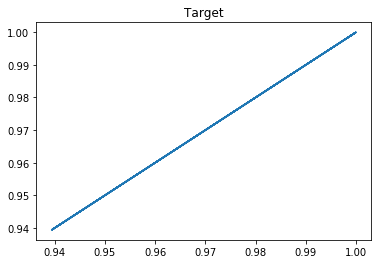

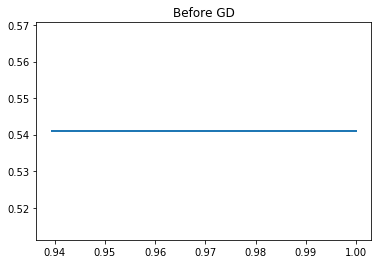

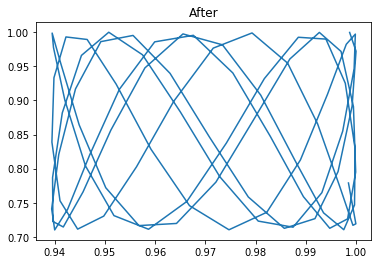

In [40]:
import numpy as np
import matplotlib.pyplot as plt
# X = np.random.rand(100,2)
data1 = np.asarray([1.0 * i for i in range(100)])
data2 = np.flip(data1, 0)
X = np.stack((data1, data2), -1)
# test weights
w1, w2, w3 = 0.35, 0.76, 0.89

# Attempt backpropagation
ytest = np.cos(w1*np.sin(w2*X[:,0] + w3*X[:,1]))
#ytest = np.sin(w1*X[:,0] + w2*X[:,0])
#ytest = np.tanh(0.35 * X[:,0])
prog = [Variable(loc=0), Variable(loc=1), Add(), Sin(), Cos()]
#prog = [Variable(loc=0), Variable(loc=1), Add(), Sin()]
#prog = [Variable(loc=0), Tanh()]
stack = []
for p in prog:
    p.evaluate(stack, X)
yhat2 = np.array(stack[-1])

cost_fcn = CostSquaredDifference(ytest)
error = cost_fcn.evaluate(yhat2)
print('Error before GD: ' + str(np.mean(error)))

GD = Auto_backprop(prog, cost_fcn, X, ytest, 10,0.1)
prog = GD.start()
stack = []
for p in prog:
    p.evaluate(stack, X)
yhat3 = np.array(stack[-1])
error = cost_fcn.evaluate(yhat3)
print('Error after GD: ' + str(np.mean(error)))

h0 = plt.figure()
plt.plot(ytest,ytest)
plt.title('Target')
plt.show()

h1 = plt.figure()
plt.plot(ytest,yhat2)
plt.title('Before GD')
plt.show()

h2 = plt.figure()
plt.plot(ytest,yhat3)
plt.title('After')
plt.show()
